<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/dECM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Filas extraídas: 4710
  well  time_min     OD
0   A1       0.2  0.407
1   A2       0.2  0.462
2   A3       0.2  0.297
3   A4       0.2  0.395
4   A5       0.2  0.445
  well  time_min     OD           cond
0   A1       0.2  0.407    PAA 24h pH7
1   A2       0.2  0.462    PAA 24h pH7
2   A3       0.2  0.297    PAA 24h pH7
3   A4       0.2  0.395  PAA 24h no pH
4   A5       0.2  0.445  PAA 24h no pH
Condiciones detectadas: ['PAA 24h pH7' 'PAA 24h no pH' 'No PAA 24h pH7' 'No PAA 24h no pH'
 'PAA 48h pH7' 'PAA 48h no pH' 'No PAA 48h pH7' 'No PAA 48h no pH'
 'Rat pH7' 'Rat no pH' 'Bov pH7' 'Bov no pH' 'Control pH7']
   time_min              cond   OD_mean     OD_sd  n
0       0.2  No PAA 24h no pH  0.285333  0.012503  3
1       0.2    No PAA 24h pH7  0.270333  0.008386  3
2       0.2  No PAA 48h no pH  0.298333  0.003512  3
3       0.2    No PAA 48h pH7  0.277667  0.023438  3
4       0.2     PAA 24h no pH  0.423333  0.025658  3
Condiciones resumen: ['No PAA 24h no pH' 'No PAA 24h pH7' 'No PA

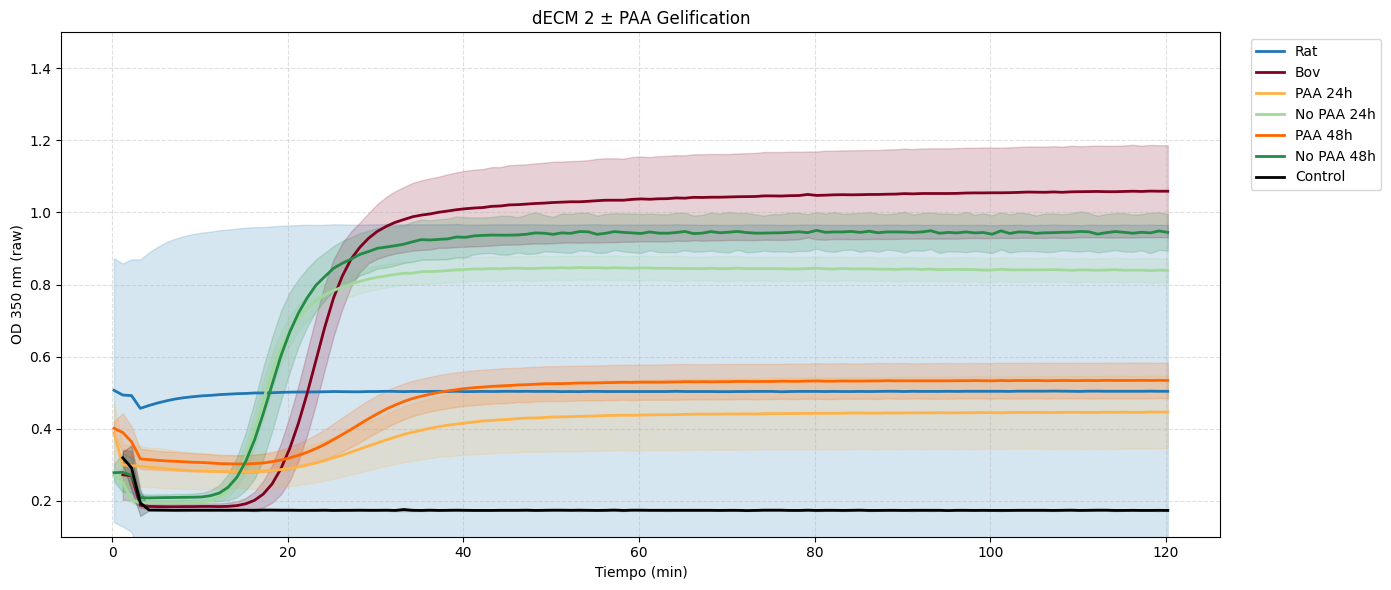

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# =========================
# 1) Cargar archivo bruto
# =========================
# Ajusta la ruta si hace falta
df_raw = pd.read_excel("/content/dECM2_Berta.xlsx", header=None)

# =========================
# 2) Detectar filas de tiempo
# =========================
mask_time = df_raw[0].astype(str).str.contains(r"^350\s*-\s*Time", na=False)
time_rows = df_raw.index[mask_time].tolist()

def extraer_minutos(txt):
    m = re.search(r"\((\d+):(\d+):(\d+)\)", str(txt))
    if m:
        h, m_, s = map(int, m.groups())
        return h*60 + m_ + s/60
    return np.nan

tiempos_min = [extraer_minutos(df_raw.loc[r, 0]) for r in time_rows]

# =========================
# 3) Extraer la cuadrícula A–H, columnas 1–6
# =========================
registros = []

for i, start in enumerate(time_rows):
    t_min = tiempos_min[i]

    # La cuadrícula de este archivo empieza 2 filas después del marcador "350 - Time"
    grid_start = start + 2

    # Filas A–H (8 filas)
    for fila in range(8):
        row_idx = grid_start + fila
        row_letter = df_raw.loc[row_idx, 1]

        if not isinstance(row_letter, str):
            continue

        for col in range(1, 13):  # o 1–6 si solo lees 6 columnas
            od = df_raw.loc[row_idx, col+1]
            if pd.isna(od):
                continue

            well = f"{row_letter}{col}"
            registros.append([well, t_min, od])

df_long = pd.DataFrame(registros, columns=["well", "time_min", "OD"])
print("Filas extraídas:", len(df_long))
print(df_long.head())

# =========================
# 4) Mapa de pocillos → condición (con info de pH interno)
# =========================
# Filas/condición base (igual que me has dicho)
row_to_base = {
    "A": "PAA 24h",
    "B": "No PAA 24h",
    "C": "PAA 48h",
    "D": "No PAA 48h",
    "E": "Rat",
    "F": "Bov",
    "G": "Control"
}

well_cond_map = {}

# Columnas 1–3 = pH 7
# Columnas 4–6 = pH original (no pH)
for row, base in row_to_base.items():
    # pH 7
    for col in [1, 2, 3]:
        well_cond_map[f"{row}{col}"] = base + " pH7"
    # pH original / no pH
    for col in [4, 5, 6]:
        well_cond_map[f"{row}{col}"] = base + " no pH"

df_long["cond"] = df_long["well"].map(well_cond_map)
df_long = df_long.dropna(subset=["cond"])

print(df_long.head())
print("Condiciones detectadas:", df_long["cond"].unique())

# =========================
# 5) Resumen por tiempo y condición
# =========================
summary_raw = (
    df_long.groupby(["time_min", "cond"])
    .agg(
        OD_mean=("OD", "mean"),
        OD_sd=("OD", "std"),
        n=("OD", "count")
    )
    .reset_index()
)

print(summary_raw.head())
print("Condiciones resumen:", summary_raw["cond"].unique())

# =========================
# 6) Quedarnos SOLO con pH 7
#    y simplificar nombres de condición
# =========================
mask_ph7 = summary_raw["cond"].str.contains("pH7")
summary_ph7 = summary_raw[mask_ph7].copy()

# Quitar la coletilla " pH7" para que en la leyenda NO salga "pH7"
summary_ph7["cond_simple"] = summary_ph7["cond"].str.replace(" pH7", "", regex=False)
print("Condiciones (simple):", summary_ph7["cond_simple"].unique())

# Orden de la leyenda (sin pH)
orden_leyenda_simple = [
    "Rat",
    "Bov",
    "PAA 24h",
    "No PAA 24h",
    "PAA 48h",
    "No PAA 48h",
    "Control"
]

# =========================
# 7) Colores (los mismos que te funcionaban)
# =========================
colores_simple = {
    # Rat / Bov
    "Rat": "#1f77b4",       # azul
    "Bov": "#800020",       # granate

    # PAA (naranja)
    "PAA 24h": "#ffb347",   # naranja claro (visible)
    "PAA 48h": "#ff6600",   # naranja fuerte

    # No PAA (verde)
    "No PAA 24h": "#a1d99b",  # verde claro
    "No PAA 48h": "#238b45",  # verde fuerte

    # Control
    "Control": "black"
}

# =========================
# 8) Gráfica final (solo pH 7)
# =========================
plt.figure(figsize=(14, 6))

for cond in orden_leyenda_simple:
    dfc = summary_ph7[summary_ph7["cond_simple"] == cond]
    if dfc.empty:
        continue

    plt.plot(
        dfc["time_min"],
        dfc["OD_mean"],
        color=colores_simple[cond],
        label=cond,
        linewidth=2
    )
    plt.fill_between(
        dfc["time_min"],
        dfc["OD_mean"] - dfc["OD_sd"],
        dfc["OD_mean"] + dfc["OD_sd"],
        color=colores_simple[cond],
        alpha=0.18
    )

plt.title("dECM 2 ± PAA Gelification")
plt.xlabel("Tiempo (min)")
plt.ylabel("OD 350 nm (raw)")
plt.ylim(0.1, 1.5)
plt.grid(True, linestyle="--", alpha=0.4)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


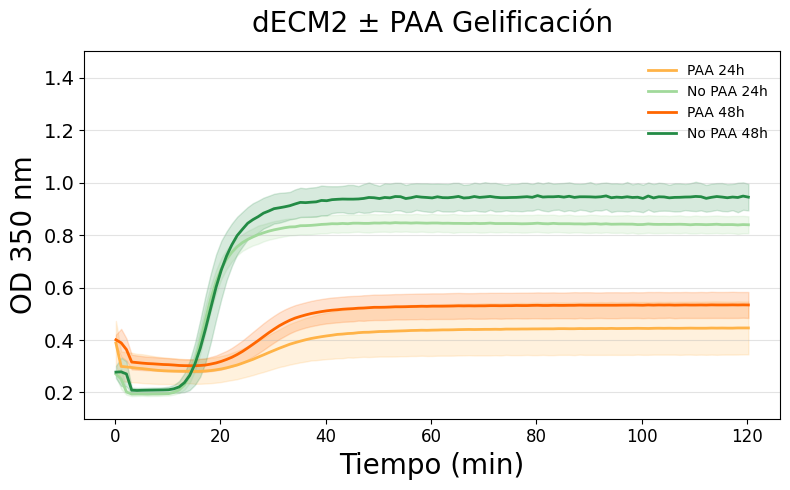

In [4]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

# =========================
# 8) Gráfica final SOLO PAA / NO PAA (24h y 48h) — pH7
# =========================

# Condiciones que SÍ queremos mostrar
conds_plot = [
    "PAA 24h",
    "No PAA 24h",
    "PAA 48h",
    "No PAA 48h"
]

fig, ax = plt.subplots(figsize=(8, 5))

for cond in conds_plot:
    dfc = summary_ph7[summary_ph7["cond_simple"] == cond]
    if dfc.empty:
        continue

    ax.plot(
        dfc["time_min"],
        dfc["OD_mean"],
        color=colores_simple[cond],
        linewidth=2,
        label=cond
    )

    ax.fill_between(
        dfc["time_min"],
        dfc["OD_mean"] - dfc["OD_sd"],
        dfc["OD_mean"] + dfc["OD_sd"],
        color=colores_simple[cond],
        alpha=0.18
    )

# ----- Límites eje Y (ajústalo si quieres) -----
ax.set_ylim(0.1, 1.5)

# ----- Textos -----
ax.set_xlabel("Tiempo (min)", fontsize=20)
ax.set_ylabel("OD 350 nm", fontsize=20)
ax.set_title("dECM2 ± PAA Gelificación", fontsize=20, pad=14)

# ----- Ticks -----
ax.tick_params(axis="y", labelsize=14)

for label in ax.get_xticklabels():
    label.set_fontsize(12)

# ----- Cuadrícula -----
ax.grid(axis="y", alpha=0.35)

# ----- Leyenda -----
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


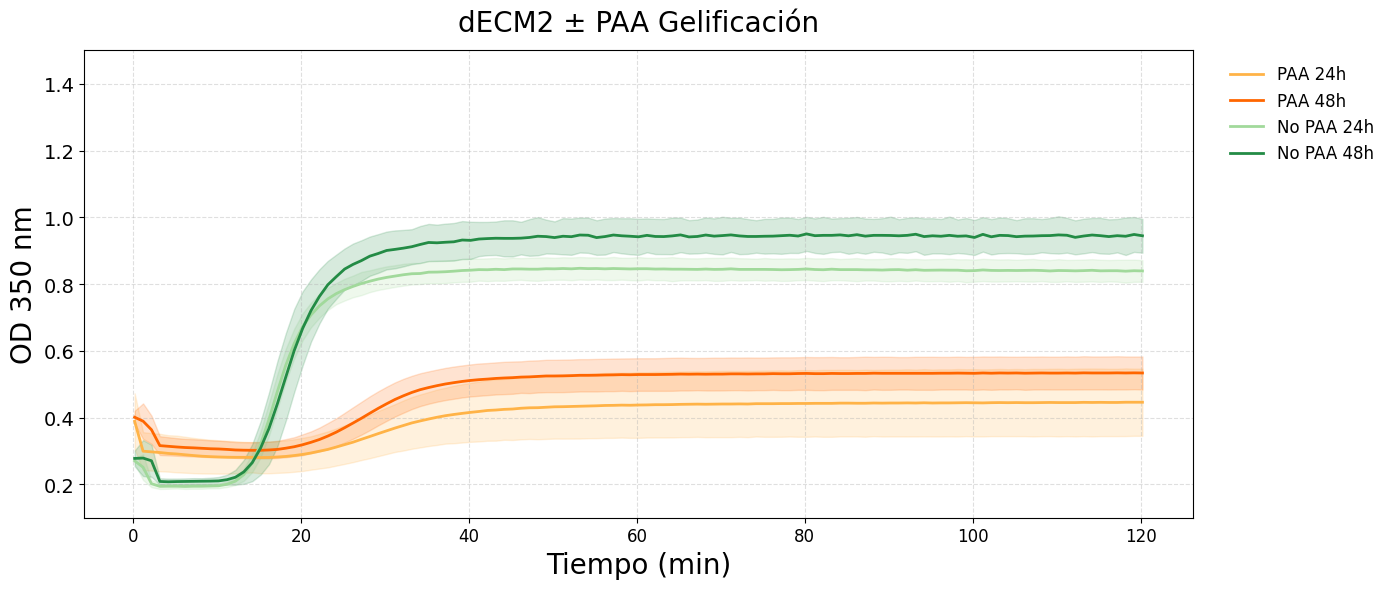

In [8]:
# =========================
# 8) Gráfica final SOLO PAA / NO PAA (24h y 48h) — pH7
#    ESTÉTICA CLAVADA A dECM1
# =========================

orden_leyenda_paa = [
    "PAA 24h",
    "PAA 48h",
    "No PAA 24h",
    "No PAA 48h",
]

plt.figure(figsize=(14, 6))

for cond in orden_leyenda_paa:
    dfc = summary_ph7[summary_ph7["cond_simple"] == cond]
    if dfc.empty:
        continue

    plt.plot(
        dfc["time_min"],
        dfc["OD_mean"],
        color=colores_simple[cond],
        label=cond,
        linewidth=2
    )

    plt.fill_between(
        dfc["time_min"],
        dfc["OD_mean"] - dfc["OD_sd"],
        dfc["OD_mean"] + dfc["OD_sd"],
        color=colores_simple[cond],
        alpha=0.18
    )

# ----- Textos -----
plt.title("dECM2 ± PAA Gelificación", fontsize=20, pad=14)
plt.xlabel("Tiempo (min)", fontsize=20)
plt.ylabel("OD 350 nm", fontsize=20)

# ----- Ejes -----
plt.ylim(0.1, 1.5)

# ----- Ticks -----
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=12)

# ----- Cuadrícula (idéntica a dECM1) -----
plt.grid(True, linestyle="--", alpha=0.4)

# ----- Leyenda FUERA, a la derecha -----
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False,
    fontsize=12
)

plt.tight_layout()
plt.show()


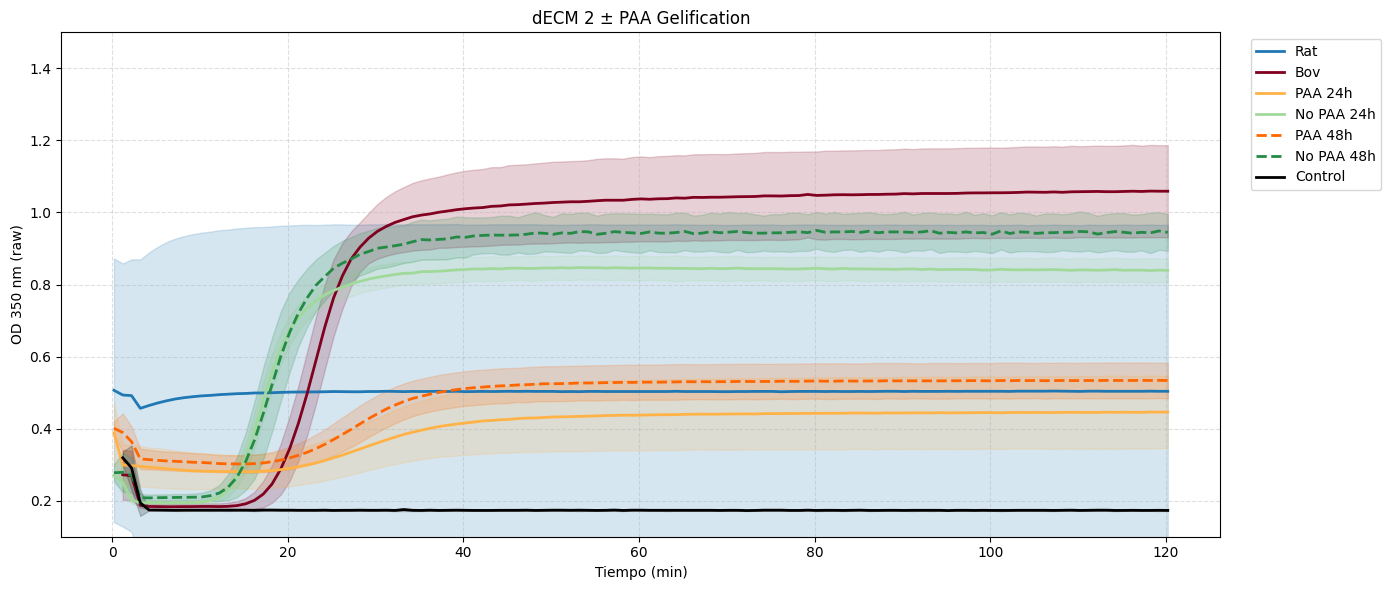

In [2]:
estilos = {
    "PAA 24h": "-",
    "No PAA 24h": "-",
    "PAA 48h": "--",       # 48h en discontinua
    "No PAA 48h": "--",
    "Rat": "-",
    "Bov": "-",
    "Control": "-"
}

plt.figure(figsize=(14,6))

for cond in orden_leyenda_simple:
    dfc = summary_ph7[summary_ph7["cond_simple"] == cond]
    if dfc.empty:
        continue

    plt.plot(
        dfc["time_min"],
        dfc["OD_mean"],
        color=colores_simple[cond],
        linestyle=estilos.get(cond, "-"),
        label=cond,
        linewidth=2
    )
    plt.fill_between(
        dfc["time_min"],
        dfc["OD_mean"] - dfc["OD_sd"],
        dfc["OD_mean"] + dfc["OD_sd"],
        color=colores_simple[cond],
        alpha=0.18
    )

plt.title("dECM 2 ± PAA Gelification")
plt.xlabel("Tiempo (min)")
plt.ylabel("OD 350 nm (raw)")
plt.ylim(0.1, 1.5)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
